# Introduction

## Context

Kaggle is hosting a **Climate Change Belief Analysis** competition which aims to predict an individual's belief in climate change based on historical tweet data.

The results from the prediction will help companies better understand their customer's perception on climate change. Such an analysis or prediction will help companies determine how their products will be recieved; thus guiding their marketing strategy and their production processes. The models to me trained are to be deployed to a Streamlit application which can be used remotely through the use of an AWS ec2 instance.


## Problem Statement

Companies are looking to create products and services that are environmentally friendly. They would thus like to understand their consumers' view on climate change. To address this, we are going to create Machine Learning models that are able to classify whether or not a person believes in climate change, based on their novel tweet data. Correct classification of a tweet will help companies understand consumer sentiment, which will further guide their business strategies.


## Data Sets

The data sets provided by host of the competition provide us with a message (tweet) and the tweet id. The tweets are related to the topic of climate change. 

The data sets used in the notebook:
    - train.csv : data used to train models; loaded as train_data in our notebook.
    - test.csv : data used to test the models; loaded as test_data in our notebook.
    
The train.csv data sis composed of 15819 tweets whilst the test.csv is composed of 10546 tweets. Below we go through the data sets to try and understand its composition further.

# Comet- Version control setup

In [ ]:
# !pip install comet_ml

In [ ]:
#from comet_ml import Experiment

In [ ]:
#experiment = Experiment(api_key="KocQlMUqLsntXlqfK65whOpu7",
#                       project_name="Team_RM_4", workspace="ghp042")

# Data Exploration
## Import packages and load data files
###### task: import and load data
We start off by importing packages and loading data

In [ ]:
# !pip install spacy
# import spacy.cli
# spacy.cli.download("en_core_web_lg")

# !pip install nltk
# import nltk
# nltk.download('all')

# !pip install emoji
# !pip install pickle

In [ ]:
# import packages
import pandas as pd
import numpy as np
import pickle
import bz2
import _pickle as cPickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import re
import emoji
import string
import spacy
import nltk
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import TreebankWordTokenizer, SnowballStemmer

nlp = spacy.load('en_core_web_lg')
stop_words = stopwords.words('english')
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load Data
train_data = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/train.csv',index_col='tweetid')
test_data = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/test.csv',index_col='tweetid')

## Variable Descriptions

- **sentiment**: Sentiment of tweet (pro, anti, neutral,news).

- **message**: Tweet body (raw tweet).

- **tweetid**: Twitter unique id (unique integer).

## Target Variable (sentiment)
-  **1 : Pro** --> the tweet supports the belief of a man-made climate change.
-  **2 : News** --> the tweet links to factual news about climate change.
-  **0 : Neutral** --> the tweet neither supports nor refutes the belief of a man-made climate change.
- **-1 : Anti** --> the tweet does not believe in a man made climate change

###### task: display the shape of the data sets
Here we display the shape of both the test and the train data to get an understanding of the features in the data sets. Below, we can see that the train data has 15819 rows of tweets and 2 columns. The columns would be the sentiment as well as the message. However, the test data only has one column (message). From the models that will be trained, we should be able to create a sentiment column for the test data too. The entries for this column will be predicted from the train data.

In [ ]:
print(f'Train data shape:\t{train_data.shape}\nTest data shape:\t{test_data.shape}')

Train data shape:	(15819, 2)
Test data shape:	(10546, 1)


###### task: Display the number of entries per category in the sentiment column
This is done to try and understand the distribution of entries in the sentiment column. Given that this is our target variable (sentiment), it is important that the data is somewhat balanced to avoid bias towards the categories with higher entries. That is, to reduce the likelihood that predictions will classify tweets as the category with the most entries.

Below we have created a dataframe that shows the number of entries per category and the percentage of those entries as a faction of the total entries.

In [ ]:
# count the entries per column and save them in a dataframe
categories = train_data['sentiment'].value_counts().to_frame()
categories.index.rename('categories',inplace=True)
categories.rename({'sentiment':'no_of_entries'},axis=1,inplace=True)
categories['percentage'] = [round(count/len(train_data),2) for count in categories['no_of_entries']]
categories

,no_of_entries,percentage
categories,,
1,8530,0.54
2,3640,0.23
0,2353,0.15
-1,1296,0.08


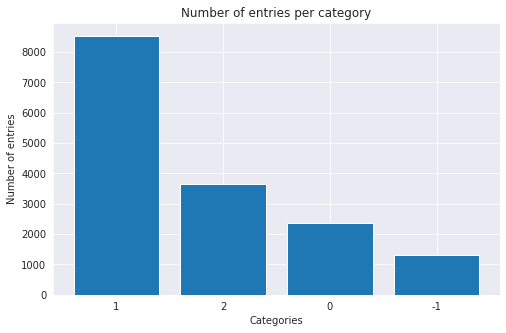

In [ ]:
# plot a bar chart which shows the distribution of the entries
plt.figure(figsize=(8,5))

plt.bar(x=['1','2','0','-1'],height=categories['no_of_entries'])
plt.title('Number of entries per category')
plt.xlabel('Categories')
plt.ylabel('Number of entries')
plt.show()
#del categories

As it can be seen above, the sentiment belonging to category 1 (Pro climate change belief) is significantly higher than the other categories. In comparison to category -1 (Anti climate change belief), if a model were to be trained with this two categories only, the model not be a good classifier as it would penalise the smaller category by predicting category 1 more often. In the data processing section of this notebook, we will look into methods like resampling to try and balance the distribution of the entries.

###### task: display the head of both the test and train data

In [ ]:
train_data.head()

,sentiment,message
tweetid,,
625221,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
126103,1,It's not like we lack evidence of anthropogenic global warming
698562,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight"


In [ ]:
test_data.head()

,message
tweetid,
169760,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq
35326,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj
224985,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;.."
476263,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax
872928,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican


## Missing Values
In this section we will be looking out for any missing values (i.e: np.nan values) and or all the tweets that are just empty strings.
- In the code cell below, we can see that no column of the train data has np.nan values.

In [ ]:
pd.DataFrame(train_data.isnull().sum(),columns=['mising_values'])

,mising_values
sentiment,0
message,0


- Here we seek to remove any empty strings from the 'message' column.

In [ ]:
print(f"Length before check:\t{len(train_data)}")

blanks = [] # store the indices of the space's tweets

for index, sent, mess in train_data.itertuples():
    if type(mess)==str:
        if mess.isspace():
            blanks.append(index)

# drop rows from dataframe if there are any empty tweets/strings            
train_data.drop(blanks,axis=0,inplace=True)

print(f"Length after check:\t{len(train_data)}")

Length before check:	15819
Length after check:	15819


As it can be seen from the above, there aren't any np.nan values nor are there any empty strings from the train_data dataframe.
What we are going to explore next is if there are any tweets that might not be sufficient in length to form an english sentence (say a tweet with one, two or maybe even three words).

In [ ]:
print(f'''Number of tweets that might not form an english sentence:
      {len([tweet for tweet in train_data.message if len(tweet)<=5])}''')

Number of tweets that might not form an english sentence:
      0


In [ ]:
# all_tokens = []

# bag_of_words = {}

# for tweet in train_data.message:
    
#     for word in nlp(tweet):
#         if word.text not in frequency.keys():
#             frequency[word.text] = 1
            
#             if word.text not in all_tokens:
#                 all_tokens.append(token.text)
#         else:
#             frequency[word.text] += 1
            
#             if word.text not in all_tokens:
#                 all_tokens.append(token.text)

###### Conclude
In this section we managed to import packages, load data, descibe the features and the target variable. We have also managed to look at the head (top five entries) of the dataframes. We have looked at the possibility of empty strings, np.nan values and even tweets (messages) that might not be sufficient enough to form an english sentence that makes sense. After this exploration, we have't performed any transformation on the data.

Before we go into any Data transformation or hyperparameter tunning, we fit models with the raw data. Once we have looked at the models before any preprocessing, we will then explore different methods of how we can go about preprocessing our data to better improve the performance of our models.

# Base Models
Train models with minimal data preprocessing.
Given the nature of the feature (message column), we will apply the term frequency–inverse document frequency Vectorizer (TfidfVectorizer) to the data so that it can be converted to a matrix of TF-IDF features, which are numerical and a machine learning algorithm can understand.

**Models to be trained**:
- Logistic Regression
- Support Vector Classification (SVC)
- Linear SVC
- Multinomial Naive Bayes classifier
- Random Forest Classifier
- Neural Network Sequence model
- K Nearest Neighbors Classifier
- Ada Boost Classifier
- Gradient Boost Classifier


All of the above models will be trained through pipelines.

###### task: import packages
Import packages that will make the modelling possible.

In [ ]:
from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

Using TensorFlow backend.


## Split the data
Split the train_data into training and testing data. This is to make sure that there isn't any leakage of information when we actually fit the test_data that we imported. To avoid overfitting, we are using the train_data to train and test our models.

In [ ]:
# split into dependent and independent arrays
X = train_data['message'].values
y = train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Create pipelines
###### task: create pipelines with a vectorizer.
The pipelines created here are to be used to train the specified models above. The pipelines will apply the TfidfVectorizer to the training data before it fits the model. The TfidfVectorizer will tokenize the tweets, learn the vocabulary and inverse document frequency weightings to create numeric vectors which can be understood by prediction models.

In [ ]:
# SVC pipeline
svc_clf = Pipeline([('vectorizer',TfidfVectorizer()),('SVC',SVC())])

# LinearSVC pipeline
linear_svc_clf = Pipeline([('vectorizer',TfidfVectorizer()),
                            ('Linear_SVC',LinearSVC())])

# Random Forest Classiffier pipeline
random_f_clf = Pipeline([('vectorizer',TfidfVectorizer()),
                         ('Random_Forest',RandomForestClassifier())])

# MultinomialNB pipeline
multinom_clf = Pipeline([('vectorizer',TfidfVectorizer()),('Multinomial',
                                                    MultinomialNB())])

# logistic Regression pipeline
logistic_clf = Pipeline([('vectorizer',TfidfVectorizer()),('Logistic_regr',
                                LogisticRegression(multi_class='ovr'))])

# K Neighbors Classifier
k_near_clf = Pipeline([('vectorizer',TfidfVectorizer()),('KNeighbors',
                                        KNeighborsClassifier(n_jobs=2))])

# Ada Boost Classifier
ada_boost_clf = Pipeline([('vectorizer',TfidfVectorizer()),('AdaBoost',
                                                AdaBoostClassifier())])

# Gradient Boost Classifier
gboost_clf = Pipeline([('vectorizer',TfidfVectorizer()),('GradientBoost',
                                                GradientBoostingClassifier())])

## Train base models
In this section we define functions that tests the five models mentioned above (logistic regression, svc, linear svc, multinomial naive's Bayes, the random classifier and a Neural Network with muliple layers). Once the models are trained, we return a performance dataframe with the weighted average F1 scores as well as the accuracy scores of the models trained. We are interested in the performance of the weighted average f1 score as it adjusts for the precision and the recall scores. The functions will also return the trained models so that they can be used to evaluate other metrices.

In [ ]:
# create a dictionary of all the untrained models
train_models = {'Logistic_regression':logistic_clf,
                  'SVC':svc_clf,'LinearSVC':linear_svc_clf,
                  'MultinomialNB':multinom_clf,'Random_Forest':random_f_clf,
                  'KNeighbors':k_near_clf, 'AdaBoost':ada_boost_clf,
                  'GradientBoost':gboost_clf}

In [ ]:
def models_to_train(X_train,X_test,y_train,y_test,train_models):
    '''
    Train models and return a dataframe of their perfomance. The function
    also returns the trained models for later use.
    
    Parameters
    ----------
    X_train : numpy array
        A numpy array of the shape (len(X_train), n), where n is any integer
        greater than 0.
    X_test : numpy array
        A numpy array of the shape (len(X_test), n), where n is any integer
        greater than 0.
    y_train : numpy array
        A numpy array of the shape(len(y_train),), with the values being the
        categories or target values.
    
    y_train : numpy array
        A numpy array of the shape(len(y_train),), with the values being the
        categories or target values
    trained_models : dict
       A dictionary of untrained models/pipelines.

    Returns
    -------
    dataframe : pandas.core.frame.DataFrame
        A pandas dataframe with two columns; weighted average f1 score and the
        accuracy score of each model.
    dictionary : dict
        A dictionary of all the trained models
    '''
    trained_models = train_models.copy()
    performance = {} # dictionary to store performance
    i = 1
    
    for name,model in trained_models.items():
        
        print(f'Training model {i} of {len(trained_models)}: {name}')
        i+=1
        # fit the model
        model.fit(X_train, y_train)
        
        # prediction of y
        y_predicted = model.predict(X_test)

        # calculate the weighted average score and the accuracy score.
        weighted_avg = classification_report(y_test,y_predicted)[-15:-11]
        acc_score = accuracy_score(y_test,y_predicted)

        performance[name] = {'weighted_average':float(weighted_avg),
                            'accuracy_score':round(acc_score,4)}

        #print(f"{name}:\n{classification_report(y_test,y_predicted)}\n")
    
    # convert the performance dictionary to a dataframe
    performance = pd.DataFrame(performance).T.sort_values(by='weighted_average',
                                                          ascending=False)
    
    return performance, trained_models

The function above trains the logistic regression, svc, linear svc, multinomialNB and the random forest classiffier. The code cell below applies the above defined function:

In [ ]:
# run the function to train the models
performance, trained_models = models_to_train(X_train,X_test,y_train,y_test,
                                              train_models)

Training model 1 of 8: Logistic_regression
Training model 2 of 8: SVC
Training model 3 of 8: LinearSVC
Training model 4 of 8: MultinomialNB
Training model 5 of 8: Random_Forest
Training model 6 of 8: KNeighbors
Training model 7 of 8: AdaBoost
Training model 8 of 8: GradientBoost


###### task: define a neural network function
The neural network will use the Sequential method with a maximum number of words of 50000, maximum sequence of 250 and an embedding of 100. The function will first tokenize the data, split it accordingly and then train a Sequencial model. We will be doing a recurrent network. This is done to make sure that there is little to no linearity in the features that are used to train the model. Once the model has been trained, we return a dataframe of the weighted average f1 score as well as the accuracy score. Like the previous function, we will be returning the trained model too so that it can be reused later if need be

In [ ]:
def sequence_model(df,performance,col='message',epochs=5):
    '''
    Return a dataframe of performance and a trained model.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        A pandas dataframe with the columns 'sequence' and 'message'.
    
    performance : pandas.core.frame.DataFrame
        A pandas dataframe with performance metrices for previously
        trained models.
        
    Returns
    -------
    dataframe : pandas.core.frame.DataFrame
        A performance dataframe with the weighted f1 scores and the 
        accuracy score of each model trained.
    keras model : keras.engine.sequential.Sequential
        A sequential model that can be used for predictions.
    '''
    
    max_no_words, max_sequence, embedding = 50000, 250, 100

    tokenizer = Tokenizer(num_words=max_no_words)
    tokenizer.fit_on_texts(df[col].values)
    word_index  = tokenizer.word_index

    X = tokenizer.texts_to_sequences(df[col].values)
    X = pad_sequences(X,maxlen=max_sequence)

    y = to_categorical(df['sentiment'].values,num_classes=4)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=4)
    
    # instantiate a sequential model.
    model = Sequential()
    
    # add layers to the model
    model.add(Embedding(max_no_words,embedding,input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                  metrics=['accuracy'])

    # fit the model with 6 epochs of batxh size 50.
    model.fit(X_train,y_train,epochs=epochs,batch_size=50,
            callbacks=[EarlyStopping(monitor='val_loss',
            patience=3, min_delta=0.0001)],verbose=1,validation_split=0.1)
    
    # make predictions
    y_predicted = model.predict(X_test)
    y_predicted = y_predicted.argmax(axis=1)
    y_test=y_test.argmax(axis=1)

    # calculate performance matrices
    weighted_avg = classification_report(y_test,y_predicted)[-15:-11]
    acc_score = accuracy_score(y_test,y_predicted)
    
    model_performance = pd.Series(data={'weighted_average':weighted_avg,
                      'accuracy_score':acc_score},name='Sequential')
    
    performance = performance.append(model_performance,
                                     ignore_index=False).astype('float')
    
    performance = performance.sort_values(by='weighted_average',ascending=False)
    
    return performance, model

Apply the function above and add the returned model to the trained models dictionary returned by the models_to_train() function. Due to the time it takes for the model to train, we have saved it as a .pbz2 file (compressed pickle file). Here we simply load the model.

In [ ]:
performance, model = sequence_model(train_data,performance)
trained_models['Sequential'] = model

Execute the code cell below.

In [ ]:
# # save the model
# # with bz2.BZ2File("base_sequence.pbz2", "wb") as f:
# #     cPickle.dump(model, f)

# # load the saved model and add it to the trained_models dictionary
# # model = cPickle.load(bz2.BZ2File("base_sequence.pbz2", "rb"))
# # trained_models['Sequential'] = model

# # save the performance dataframe and load it.
# # performance.to_csv('base_performance.csv')
# performance = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/base_performance.csv',index_col=0)

## Performance Evaluation
The dataframe displayed below shows the weighted average f1 score and the accuracy scores for all the base models that have been trained. The LinearSVC model has outperformed all the base models. This is followed by the Sequential neural network model.


In [ ]:
performance

,weighted_average,accuracy_score
LinearSVC,0.74,0.75010
Sequential,0.72,0.72145
SVC,0.70,0.72730
Logistic_regression,0.69,0.71660
Random_Forest,0.67,0.70160
KNeighbors,0.66,0.67210
GradientBoost,0.66,0.68460
AdaBoost,0.61,0.63230
MultinomialNB,0.52,0.61930


The accuracy score is consistently above the the weighted average f1 score for all the models that have been trained. This can be attributed to the imbalance in the entries of the sentiment column in the original data. This will however be explored in the nect section as we preprocess our data to try and improve the performance of our model.

From the models that we have trained by far, the LinearSVC is currently outperforming all the other models that have been trained on the same data. We will however opt to work on improving the performance of all our models in an attempt to get a model that will perform best.

In [ ]:
def model_scores(performance):
    '''Create a bar chart of the weighted f1 score and the accuracy score.'''
    
    x = list(performance.index)
    height = [i*100 for i in performance.weighted_average]
    fig= plt.figure(figsize=(12,6))
    plt.bar(x,height,label='weighted_avg',)
    plt.bar(x,height=[i*100 for i in performance.accuracy_score],alpha=0.2,label='accuracy')
    plt.title('Weighted Average F1 score')
    plt.xlabel('Models')
    plt.ylabel('Weighted Avg in %')
    plt.legend()
    plt.xticks(rotation=45)
    
    return fig

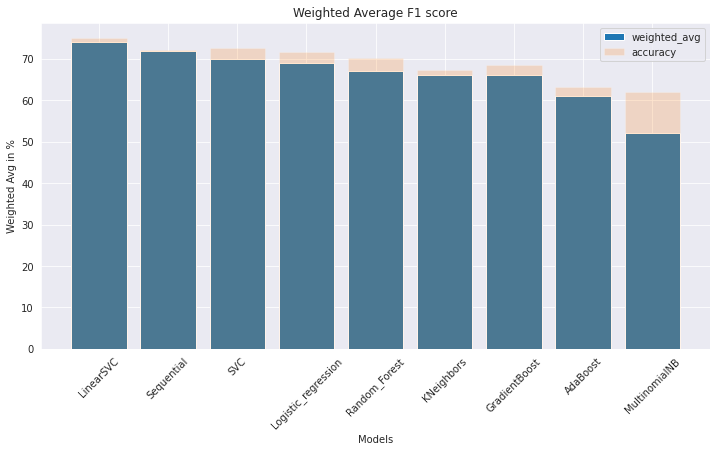

In [ ]:
_ = model_scores(performance)

###### task: visualize at the distribution of the classifications of all the trained models
In this section we are looking at how the models have distributed the classifications across the sentiment entries. We start off by creating a dataframe that stores the counts of each classification.

In [ ]:
def distribution_of_sentiment(trained_models,X_test):
    '''Create a pandas dataframe with the counts of each classification per model.
    
    Parameters
    ----------
    trained_models : dict
        A dictionary of trained models.
    X_test : numpy array
        A numpy array with the 'message' content from the train dataframe.
        
    Returns
    -------
    dataframe: pandas.core.frame.DataFrame
        A pandas dataframe with the count of classifications per model.
    '''
    
    predictions = pd.DataFrame(trained_models['Logistic_regression'].predict(X_test),
                               columns=['Logistic_regression'])
    predictions = pd.DataFrame(predictions['Logistic_regression'].value_counts())

    for name in trained_models.keys():

        if name != 'Sequential':
            predictions[name] = pd.Series(trained_models[name].predict(X_test)).value_counts()

        else:
            tokenizer = Tokenizer(num_words=50000)
            tokenizer.fit_on_texts(X_test)

            seq = trained_models[name].predict(pad_sequences(
                    tokenizer.texts_to_sequences(X_test),maxlen=250)).argmax(axis=1)

            data = []
            for x in seq:
                if x !=3:
                    data.append(x)
                else:
                    data.append(-1)

            predictions[name] = pd.Series(data).value_counts()
            
    predictions.fillna(0,inplace=True)
    
    return predictions

In [ ]:
predictions = distribution_of_sentiment(trained_models,X_test)
predictions.T

,1,2,0,-1
Logistic_regression,3200.0,1171.0,271.0,104.0
SVC,3242.0,1176.0,221.0,107.0
LinearSVC,2825.0,1226.0,439.0,256.0
MultinomialNB,4359.0,350.0,37.0,0.0
Random_Forest,3322.0,1055.0,305.0,64.0
KNeighbors,2882.0,1046.0,534.0,284.0
AdaBoost,2908.0,1312.0,381.0,145.0
GradientBoost,3185.0,1154.0,296.0,111.0
Sequential,3222.0,657.0,713.0,154.0


From the plots below, we can see that the distribution of the classifications follows that of the original dataframe. The multinomialNB model has however done a bad job at classifying the sentiments. The model proves to classify most of the tweets as either 1 (Pro climate change belief) or as 2 (News). As per the models we have trained, this explains or rather is consistent with how the Multinomial model's accuracy and f1-weighted average score is performing the worst amongst our models.

In this activity, were interested in finding out if there might be any anomalies between the distribution of the sentiment classifications in the original data and the classifications from the predictions in the models. As it can be seen, the distributions are what we would have expected.

In [ ]:
def sentiment_figures(predictions):
    '''Return a figure that visualises the classifications per model.'''
    
    fig, ax = plt.subplots(3,3,figsize=(11,6))
    
    count=0
    
    for row in range(3):
        for column in range(3):
            mask = predictions.columns[count]
            ax[row,column].bar(x=['1','2','0','-1'],height=predictions[mask])
            ax[row,column].set_title(mask)
            count +=1

    plt.tight_layout()
    
    return fig

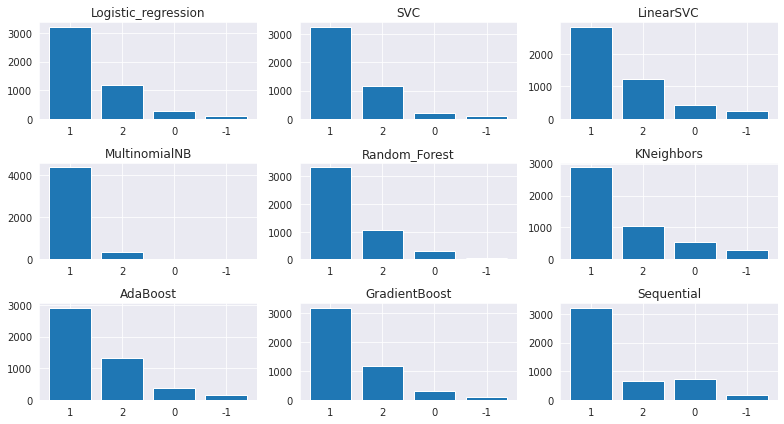

In [ ]:
_ = sentiment_figures(predictions)

##### Conclusion
In this section we trained base mosels with the raw data and minimal data preprocessing and little to no hyperparameter tuning. This was done with the intention to get an idea of which models can be ideal to train going forward, given their performance (weighted average f1 score). From our experiment, we have seen that the LinearSVC as well as the Sequential model have the highest weighted average f1 scores.

In the following sections, we are going to explore multiple methods to try and improve the performance of our models.

# Data Transformation
In this section, we are going to explore different ways we can go about transforming the data in an attempt to try and improve the performance of our models. This includes the removal of links, special characters, entities etc.

## Data resampling
A we have already identified in section 2 of this notebook (Data Exploration), the data is not balanced ; that is, there are more entries for one sentiment relative to the other. For that reason, we have explored the upsampling as well as the downsampling method to try and balance out the data. However, upon doing that experiment, we realised that the data doesn't really have to be balanced as people are being gradually becoming aware of the impact of climate change and global warming.

For that reason, it should be expected that more and more people would be in support of the climate change belief. Given that realisation, we opted to rather upsample all the entries per sentiment. This was done to preserve the reflection of reality of the data as well as to try and improve the performance of the models.

In [ ]:
# import the resampling package
from sklearn.utils import resample

The code cell below splits the data into all the sentiments (0,1,2,-1). After splitting the data in that manner, we use the resampling package to upsample the entries per category. Here we increased category 1 (Pro) by 20% of the length of category 1 entries. Category 2 (news) was increased to the length of the original category 1 entries. Category 0 (Neutral) was increaed to 80% of the length of the new category 2. The last category was increased by a factor of 4.

In [ ]:
def UpSampleData(train_data):
    '''Return dataframes with upsampled sentiment categories'''
    
    # split the data by sentiment
    sent_1 = train_data[train_data.sentiment==1]
    sent_2 = train_data[train_data.sentiment==2]
    sent_0 = train_data[train_data.sentiment==0]
    sent_3 = train_data[train_data.sentiment==-1]

    # resample the data
    sent_2 = resample(sent_2,replace=True,n_samples=len(sent_1),random_state=4)
    sent_1 = resample(sent_1,replace=True,n_samples=int(len(sent_1)*1.6),random_state=4)
    sent_0 = resample(sent_0,replace=True,n_samples=int(len(sent_2)*0.8),random_state=4)
    sent_3 = resample(sent_3,replace=True,n_samples=len(sent_3)*4,random_state=4)
    
    return sent_1,sent_2,sent_0,sent_3

sent_1,sent_2,sent_0,sent_3 = UpSampleData(train_data)


				Number of entries per category


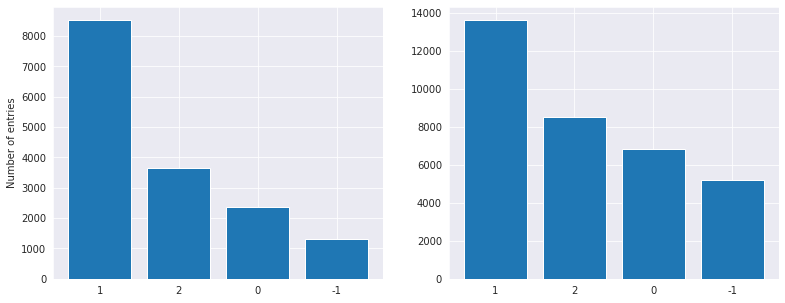

					Sentiment Categories



In [ ]:
# display the distributions
fig, ax = plt.subplots(1,2,figsize=(13,5))
print('\n\t\t\t\tNumber of entries per category')
ax[0].bar(x=['1','2','0','-1'],height=categories['no_of_entries'])
ax[1].bar(x=['1','2','0','-1'],height=[len(sent_1),len(sent_2),len(sent_0),len(sent_3)])
ax[0].set_ylabel('Number of entries')
plt.show()
print('\t\t\t\t\tSentiment Categories\n')

In [ ]:
new_train_data = pd.concat([sent_1,sent_2,sent_3,sent_0])
new_train_data.head()

,sentiment,message
tweetid,,
584136,1,RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦
77065,1,Trump won't deter us on climate change @CNNI https://t.co/4HSHSgpilp
911647,1,"RT @Travon: Between DeVos, poison water, more guns and ignoring climate change, Republicans remain the biggest threat to your child's futur…"
686607,1,@Moj_kobe The world in 'Fallout New Vegas' is a gritty prediction of our climate change future https://t.co/MIqo9oDdGu
717554,1,RT @irinnews: “Very little has been done to tackle the bigger threat: regular droughts and hurricanes caused by climate change.” \nhttps://t…


### Impact of Upsampling
Here we look at how upsampling might have affected the performance of our base models by calling the models_to_train() and the sequence_model() functions we defined in the previous section.

Due to the amount of time it takes the models below to train, we have comented out the code post the training and saving of the output from the experiment.

In [ ]:
# # Do NOT Execute!! Load Pickle files!
# # split into dependent and independent arrays
# X = new_train_data['message'].values
# y = new_train_data['sentiment'].values

# # split into training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# sampled_performance, sampled_trained_models = models_to_train(X_train,X_test,y_train,y_test,train_models)
# sampled_performance, sampled_model = sequence_model(new_train_data,sampled_performance)
# sampled_trained_models['Sequential'] = sampled_model

In [ ]:
# # save the models as pickle files.
# for name, model in sampled_trained_models.items():
#   filename = name+'.pbz2'
#   print(filename)
#   with bz2.BZ2File(filename,'wb') as file:
#     cPickle.dump(model,file)

# sampled_performance.to_csv('sampled_performance.csv')

In [ ]:
sampled_performance =pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/sampled_performance.csv',index_col=0)
sampled_performance

,weighted_average,accuracy_score
SVC,0.95,0.950200
LinearSVC,0.95,0.947300
Random_Forest,0.95,0.946100
Sequential,0.94,0.936135
Logistic_regression,0.85,0.855500
MultinomialNB,0.78,0.786500
KNeighbors,0.77,0.773500
GradientBoost,0.67,0.676600
AdaBoost,0.57,0.587600


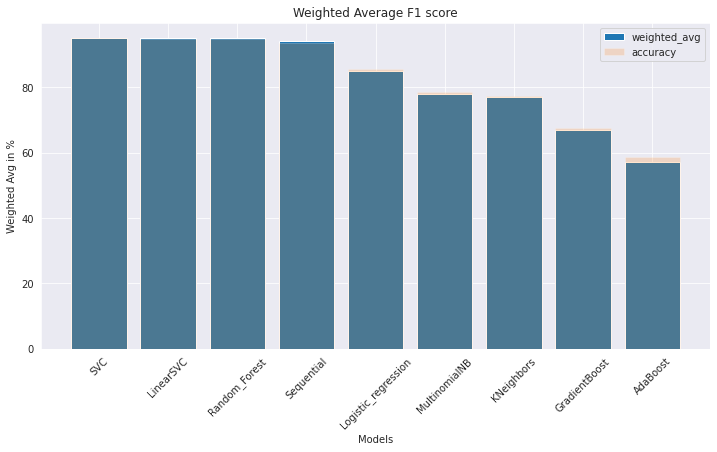

In [ ]:
_ = model_scores(sampled_performance)

The experiment to try and upscale the data has paid off as all the base models have improved their performance, be it the accuracy score or the weighted average f1 score. The Support Vector Classifier and the Random forest classifier  have outperformned the other models post the upsampling. This can be attributed to the presence of more information for the models to train on. This might be an indication of overfitting more than it might be an indication of the improvement in performance. Before we conclude this section, we explore other ways of transforming the data and see how that will impact the performance thereof.

Please note that the transformation below will be done on the original train_data dataframe. This is for computational efficiency. Upon completion of the transformation, the data will be upsampled to reflect the experiment above.

## Clean the data
### Remove Entities
The entities in the tweets don't really help us understand a customer's sentiment. For that reason, we have opted to exclude the entities from the train_data (message column). This will be replaced with an empty string.

In [ ]:
def remove_entity(tweet):
    '''Return a tweet without any entities.
    '''
    doc = nlp(tweet)
    
    # list to store entities
    entity = [x.text for x in doc.ents]
    
    # list of words without any entities
    tweet = [word.text for word in doc if word.text not in entity]
    
    # return a string
    return ' '.join(tweet)

In [ ]:
train_data['message'] = train_data['message'].apply(remove_entity)

### Demojize the data
Convert the emojis in the tweets to their meaning or descriptions. This will help us derive meaning out of the presence of emojis in tweets. The first code cell below shows the raw tweet. The following code cell shows how we demojize a tweet to return its text description.

In [ ]:
train_data['message'].loc[911385]

'lmao 😂 snowflakes ❄ ️ complaining about snowflakes ❄ ️ in = global warming 🤦 \u200d ♂ ️'

In [ ]:
emoji.demojize(train_data['message'].loc[911385])#.replace('_',' ').replace(':','')

'lmao :face_with_tears_of_joy: snowflakes :snowflake:  complaining about snowflakes :snowflake:  in = global warming :person_facepalming: \u200d :male_sign: '

###### task: create a function that will demojize the tweets
The function below takes a tweet that has emojis, demojize the tweets and then cleans the tweet. The cleaning of the tweet is only limited to removing the collons and the under scores created by the descriptions of the emojis.

In [ ]:
def demojize_tweet(df,col):
    '''Return a dataframe with no emojis.
    '''
    df[col] = df[col].apply(emoji.demojize)
    df[col] = df[col].apply(lambda x: x.replace(':','').replace('_',' '))
    
    return df

In [ ]:
# apply the function
train_data = demojize_tweet(train_data,'message')

In [ ]:
train_data['message'].loc[911385]

'lmao face with tears of joy snowflakes snowflake  complaining about snowflakes snowflake  in = global warming person facepalming \u200d male sign '

The tweet in the code cell above reflects a transformed tweet without anu emojis, yet maintaining the same information from what an emoji might convey.

### Remove links
Here we seek to remove links from tweets as they don't offer us much information in terms of predicting a customer's belief on the topic of climate change. In this section we will also remove the **@** references and the **#**'s from tweets.

In [ ]:
def remove_links(df,col):
    '''Return a tweet without any mentions (@), #'s nor links'''
    
    # Remove urls
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    pattern_url_1 = r'http[s]?//(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    
    mentions_H = r'\@\w+|\#'
    
    df[col] = df[col].replace(to_replace = pattern_url, value = 'url', regex = True)
    df[col] = df[col].replace(to_replace = pattern_url_1, value = 'url', regex = True)
    df[col] = df[col].replace(to_replace = mentions_H, value = '', regex = True)
    
    return df

In [ ]:
# store the cleaned tweets
train_data = remove_links(train_data,'message')

###### task: display the head of the data

In [ ]:
train_data.head()

,sentiment,message
tweetid,,
625221,1,"PolySciMajor chief does n't think carbon dioxide is main cause of global warming and .. wait , what ! ? url via"
126103,1,It 's not like we lack evidence of anthropogenic global warming
698562,2,Researchers say we have three years to act on climate change before it ’s too late url url …
573736,1,TodayinMaker WIRED was a pivotal year in the war on climate change url
466954,1,"It 's , and a racist , sexist , climate change denying bigot is leading in the polls ."


### Remove Punctuations
Remove the punctuations from the tweets and return the cleaned tweet. The returned tweet will be in lowwer case. The numbers in tweets will also be removed as they provide us with no information with regards to predicting a customer's sentiment.

In [ ]:
def remove_punc(tweet):
    'Return a string without any punctuation.'
    
    tokens = word_tokenize(tweet)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation+'0123456789')
    
    return ' '.join([w.translate(table) for w in tokens])

In [ ]:
train_data['message'] = train_data['message'].apply(remove_punc)

In [ ]:
train_data.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor chief does nt think carbon dioxide is main cause of global warming and wait what url via
126103,1,it s not like we lack evidence of anthropogenic global warming
698562,2,researchers say we have three years to act on climate change before it ’ s too late url url …
573736,1,todayinmaker wired was a pivotal year in the war on climate change url
466954,1,it s and a racist sexist climate change denying bigot is leading in the polls


### Remove stop words
Here we remove the stop words that might be in the tweets provided.

In [ ]:
def remove_stop_words(tweet):
    tokens = TreebankWordTokenizer().tokenize(tweet)
    return ' '.join([t for t in tokens if t not in stopwords.words('english')])

In [ ]:
train_data['message'] = train_data['message'].apply(remove_stop_words)

## Stemming and Lemmatization
What we are going to try to do in this section is to explore how we can reduce the words in tweets to their root. For this we will explore the Stemming and Lemmatization methods. We start by first exploring the stemming method. Stemming refers to the process of reducing each word to its root or base. However, stemming has a shortfall in that the roots can sometimes not be english words. For that reason, we explore the Lemmatization method which returns english words.

We will thus apply the lemmatization method to our dataset. The lemmatization method is relatively slower than the stemmer method. But for the sake of having roots or bases that are english words, we will apply lemmatization.

###### task: try the stemmer

In [ ]:
def stem_tweets(tweet):
    tokens = TreebankWordTokenizer().tokenize(tweet)
    return ' '.join([SnowballStemmer('english').stem(word) for word in  tokens])

In [ ]:
pd.DataFrame(train_data['message'].apply(stem_tweets)).head()

,message
tweetid,
625221,polyscimajor chief nt think carbon dioxid main caus global warm wait url via
126103,like lack evid anthropogen global warm
698562,research say three year act climat chang ’ late url url …
573736,todayinmak wire pivot year war climat chang url
466954,racist sexist climat chang deni bigot lead poll


###### task: apply the lemmatization method

In [ ]:
def lemmatize_tweets(tweet):
    tokens = TreebankWordTokenizer().tokenize(tweet)
    return ' '.join([WordNetLemmatizer().lemmatize(word) for word in tokens])

In [ ]:
train_data['message'] = train_data['message'].apply(lemmatize_tweets)

In [ ]:
train_data.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor chief nt think carbon dioxide main cause global warming wait url via
126103,1,like lack evidence anthropogenic global warming
698562,2,researcher say three year act climate change ’ late url url …
573736,1,todayinmaker wired pivotal year war climate change url
466954,1,racist sexist climate change denying bigot leading poll


###### upsample the transformed train data

In [ ]:
sent_1,sent_2,sent_0,sent_3 = UpSampleData(train_data)
clean_train_data = pd.concat([sent_1,sent_2,sent_3,sent_0])

## Performance Evaluation
In this section we are going to evaluate the performance of the base models post the transformation of our data. We start off by splitting the data into training and test data. We will be using the functions that were defined earlier for the evaluation below:

In [ ]:
# split into dependent and independent arrays
X = clean_train_data['message'].values
y = clean_train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [ ]:
# run the functions to train the models
post_prep_performance, post_prep_trained_models = models_to_train(X_train,X_test,y_train,y_test,train_models)
# post_prep_performance, post_prep_model = sequence_model(clean_train_data,post_prep_performance,epochs=4)
# post_prep_trained_models['Sequential'] = post_prep_model

Training model 1 of 8: Logistic_regression
Training model 2 of 8: SVC
Training model 3 of 8: LinearSVC
Training model 4 of 8: MultinomialNB
Training model 5 of 8: Random_Forest
Training model 6 of 8: KNeighbors
Training model 7 of 8: AdaBoost
Training model 8 of 8: GradientBoost


In [ ]:
# with bz2.BZ2File('post_prep_model.pbz2','wb') as file:
#      cPickle.dump(post_prep_model,file)

post_prep_model = cPickle.load(bz2.BZ2File("post_prep_model.pbz2", "rb"))
post_prep_trained_models['Sequential'] = post_prep_model


# post_prep_performance.to_csv('post_prep_performance.csv')
post_prep_performance = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/post_prep_performance.csv',index_col=0)

In the code cells below, we can see that the performance of the models has dropped after cleaning the data. This can be anticipated as we have removed multiple elements from the tweets in the data frame. We start by creating a dataframe with the weighted average f1 scores for all the experiments done by far.

In [ ]:
# create a dataframe for all trials
relative_performance = performance.merge(sampled_performance,
                        left_index=True,right_index=True,
                        suffixes=('_raw', '_upsampled')).merge(
                        post_prep_performance,left_index=True,
                        right_index=True,suffixes=('', '_clean'))
# columns to remove
remove1 = list(relative_performance.columns)[1]
remove2 = list(relative_performance.columns)[3]
remove3 = list(relative_performance.columns)[-1]

# 
relative_performance.drop([remove1,remove2,remove3],axis=1,inplace=True)
del remove1, remove2, remove3
relative_performance

,weighted_average_raw,weighted_average_upsampled,weighted_average
LinearSVC,0.74,0.95,0.90
Sequential,0.72,0.94,0.90
SVC,0.70,0.95,0.94
Logistic_regression,0.69,0.85,0.82
Random_Forest,0.67,0.95,0.94
KNeighbors,0.66,0.77,0.74
GradientBoost,0.66,0.67,0.62
AdaBoost,0.61,0.57,0.55
MultinomialNB,0.52,0.78,0.76


As it can be seen in the dataframe above, the upsampling has improved the performance of the models significantly. However, the cleaning of the data has reduced that performance gained from resampling. As it can be seen in the line graph below, the upsampled data by far performs best as it consistently improves the performance across all models. The Ada Boost model on the contrary, is not impacted significantly by the process of upsampling. If anything, it is decreasing as we upsample and clean. The gradient boost is also not impacted significantly by upsampling (relative to the other models). This can be an indication of the two model's resistance to overfitting during the training of the models.

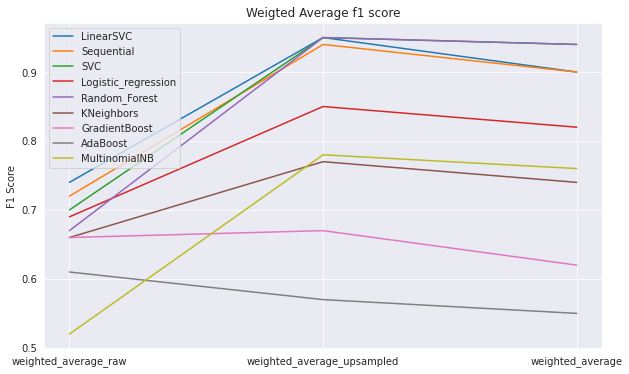

In [ ]:
 def all_models_performance(relative_performance):
    ''' plot the changes in the scores pre and post data transformation.'''
    fig = plt.figure(figsize=(10,6))

    for col in relative_performance.T.columns:
       plt.plot(relative_performance.T[col],label=col)
       plt.legend()
      
    plt.title('Weigted Average f1 score')
    plt.ylabel('F1 Score')
  
    return fig

_ = all_models_performance(relative_performance)

Below we go back to investigationg how each model has classified the sentiments when we made prdictions. As it can be seen, there aren't any anomalies in the distribution of the classifications. The distributions are as we could anticipate them to be. Unlike with the base models, the Multinomial Naives Bayes model has seen a significant improvement in its performance.The model has done better than the Gradient Boost, Ada Boost and the K nearest neighbors models in terms of it's weighted average f1 score.

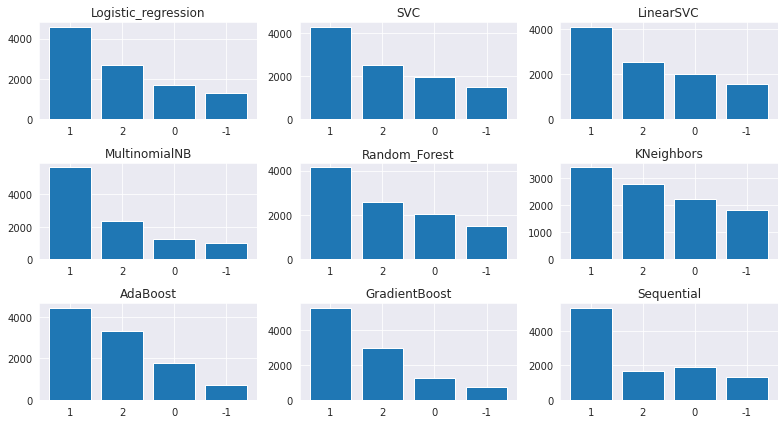

In [ ]:
post_prep_predictions = distribution_of_sentiment(post_prep_trained_models,X_test)
_ = sentiment_figures(post_prep_predictions)

As per the classification report for the multinomialNB model, we can see that the model has improved its predictive accuracy and the precision in classifying the sentiments.

In [ ]:
# print the classification report for the multinomial naives bayes
print(classification_report(post_prep_trained_models['MultinomialNB'].predict(X_test),y_test))

              precision    recall  f1-score   support

          -1       0.61      0.95      0.74      1003
           0       0.55      0.92      0.69      1242
           1       0.93      0.67      0.78      5664
           2       0.78      0.85      0.81      2347

    accuracy                           0.77     10256
   macro avg       0.72      0.84      0.75     10256
weighted avg       0.82      0.77      0.77     10256



Lastly we revisit the weighted average f1 score bar graph. As it can be seen here, the SVC and the Random forest perform best.

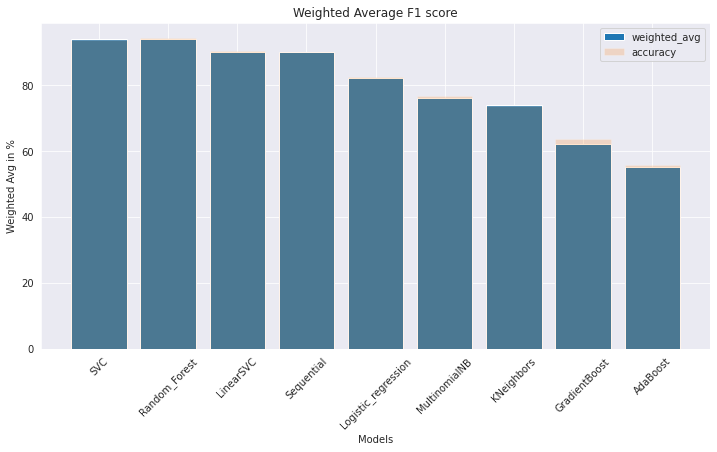

In [ ]:
_ = model_scores(post_prep_performance)

###### Conclusion
In this section we looked and upsampling and cleaning the data in the dataframe. We have seen how the models perform better when the data is upsampled. This has resulted in the SVC and the random forest having significant improvements in their performance. Prior to the above exploration, the Linear SVC model was outperforming all the base models that were trained in the Base Models section. The experiment above however suggests that the model is doing just as well as the csv and the random forest.

In the following section of the notebook, we  will be looking at different hyperparameter tunning methods to try and improve the performance further.

# Hyperparameter Tunning
In this section we are going to explore tunning the parameters for the best performing models from out base models. In the previous section we have established that the performance of the Gradient boosting and the Ada boosting models is relatively low. The inclusion of this models in this section would be redundant as we do not anticipate that they would improve in their performance.

From this section going forward, we will only include models with a weighted average f1 score above 0.80.

## Models to tune
Here we select models to use in this section.
Below we display the performance of the models sorted from the best performing model to the worst. We then trim the relative performance to the top five models.

In [ ]:
relative_performance.sort_values(by='weighted_average',ascending=False,inplace=True)
relative_performance[relative_performance['weighted_average']>0.8]

,weighted_average_raw,weighted_average_upsampled,weighted_average
SVC,0.70,0.95,0.94
Random_Forest,0.67,0.95,0.94
LinearSVC,0.74,0.95,0.90
Sequential,0.72,0.94,0.90
Logistic_regression,0.69,0.85,0.82


### Support Vector Classifier
For the parameter tunning of the support vector classifier, we will be using the sklearn GridSearchCV module. In this experiment, we will be seeking to get the best performing parameters by altering the kernel, C and the gamma of the svc model. The kernels tested are the Radial-basis function (rbf) and the polynomial kernel. This are followed by C values (Regularization parameter) of 0.25 and 1.0. We will also do the experiment using gamma values 1 and 2.

We will also do a cross validation for the models and then take the best performing model from the experiment. The grid search will use the weighted average f1 scores to rank the performances of each train in the grid search process. In the code cell below, we are creating a pipeline which we are to use in training the svc model.

In [ ]:
# specify the parameters to be used
parameters = {'kernel':('rbf','poly'), 
              'C':(0.25,1.0),
              'gamma': (1,2)}

# create a pipeline
svc_grid = Pipeline([('vectorizer',TfidfVectorizer()),
                    ('SVC',GridSearchCV(estimator=SVC(),param_grid=parameters,
                                        scoring='f1_weighted', cv=5))])

In the code cell below, we create a dictionary that will store tuned pipeline models.

In [ ]:
# create a dictionary of models to train
tune_models = {'SVC':svc_grid}

###### task: split the data into train tests arrays
Given the decline in performance post cleaning the data, we have opted to use the uncleaned, yet upsampled data to train the tuned models. Here we split the data into train test data arrays.

In [ ]:
# split into dependent and independent arrays
X = clean_train_data['message'].values
y = clean_train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

Below we train the tuned model using the function models_to_train() which was defined in the Base Models section. Due to the time it takes to train the below model, we have saved the output in a csv file.

In [ ]:
# # train the model
# tuned_performance, tuned_model = models_to_train(X_train,X_test,y_train,y_test,
#                                                  tune_models)

Training model 1 of 1: SVC


Below we upload the saved dataframe.

In [ ]:
#tuned_performance.to_csv('tuned_performance.csv')
tuned_performance = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/tuned_performance.csv',index_col=0)

In [ ]:
# y_pred =tuned_model['SVC'].predict(test_data.message.values)
# pd.DataFrame(data = y_pred,index = list(test_data.index),columns=['sentiment']).reset_index().rename({'index':'tweetid'},axis=1).set_index('tweetid').to_csv('submit_me.csv')


### Linear Support Vector Cassifier
For the LinearSVC, we are going to be using four regularization (C) values and cross validate the model 5 times. The gridsearchcv object will thus return the best performing model parameters. Like with the svc above, the model will be applied to the upsampled, but not cleaned data. In the code cell below, we start off by creating a pipeline for the model training.

In [ ]:
# specify the parameters to be used
parameters = {'C':(0.25,0.5,0.75,1.0)}

# create a pipeline with the gridsearchcv
linear_svc_grid = Pipeline([('vectorizer',TfidfVectorizer()),
                            ('Linear_SVC',GridSearchCV(estimator=LinearSVC(),
                              param_grid=parameters,scoring='f1_weighted',cv=5))])

In the code cell below, we create a dictionary that will store the tuned LinearSVC pipeline model.

In [ ]:
linsvc_model = {'LinearSVC': linear_svc_grid}

Train the tuned model.

In [ ]:
linsvc_performance, linsvc_model = models_to_train(X_train,X_test,
                                                  y_train,y_test, linsvc_model)

# add the LinearSVC model to the tuned models dictionary
#tuned_model[list(linsvc_model.keys())[0]] = list(linsvc_model.values())[0]

tuned_performance = pd.concat([tuned_performance,linsvc_performance])

Training model 1 of 1: LinearSVC


### Logistic Regression
For the logistic regression model, we are going to be using four regularization (C) values and cross validate the model 5 times. The gridsearchcv object will thus return the best performing model parameters. Like with the linearsvc above, the model will be applied to the upsampled, but not cleaned data. In the code cell below, we start off by creating a pipeline for the model training.

In [ ]:
# specify the parameters to be used
parameters = {'C':(0.25,0.5,0.75,1.0),
              'solver':('lbfgs','saga','newton-cg')}

# create a pipeline with the gridsearchcv
logistic_grid = Pipeline([('vectorizer',TfidfVectorizer()),('Logistic_regr',
                                GridSearchCV(estimator=LogisticRegression(),
                                param_grid=parameters,scoring='f1_weighted',
                                cv=5))])

In the code cell below, we create a dictionary that will store the tuned logistic regression pipeline model.


In [ ]:
logic_model = {'Logistic_regression':logistic_grid}

Train the tuned model.

In [ ]:
log_performance, log_model = models_to_train(X_train,X_test,
                                            y_train,y_test, logic_model)

# add the LinearSVC model to the tuned models dictionary
#tuned_model[list(log_model.keys())[0]] = list(log_model.values())[0]

tuned_performance = pd.concat([tuned_performance,log_performance])

Training model 1 of 1: Logistic_regression


Now that we have tunned out models, in the next section of the notebook we are going to look at how the experiment above has affected each model's performance.

## Performance Evaluation
The dataframe displayed below shows the weighted average f1 score as well as the accuracy scores of the models post the hyperparameter tuning experiment.

In [ ]:
tuned_performance

,accuracy_score,weighted_average
SVC,0.9462,0.95
LinearSVC,0.9033,0.90
Logistic_regression,0.8467,0.85


Below we merge the above dataframe with the relative performace dataframe defined in the data transformation section.

In [ ]:
# merge the new performance with the relative performance dataframe
tunned_re_performance = relative_performance.merge(tuned_performance,
                                            how='left',left_index=True,
                                            right_index=True, suffixes=(' ','_tuned'))

# drop the accuracy score column & sort accordingly
tunned_re_performance.drop('accuracy_score',axis=1,inplace=True)
tunned_re_performance.sort_values(by=list(tunned_re_performance.columns)[-1],
                                  ascending=False,inplace=True)

tunned_re_performance

,weighted_average_raw,weighted_average_upsampled,weighted_average,weighted_average_tuned
SVC,0.70,0.95,0.94,0.95
LinearSVC,0.74,0.95,0.90,0.90
Logistic_regression,0.69,0.85,0.82,0.85
Random_Forest,0.67,0.95,0.94,NaN
Sequential,0.72,0.94,0.90,NaN
MultinomialNB,0.52,0.78,0.76,NaN
KNeighbors,0.66,0.77,0.74,NaN
GradientBoost,0.66,0.67,0.62,NaN
AdaBoost,0.61,0.57,0.55,NaN


As per the data in the dataframe above, we can see that the three models that have been tuned haven't seen much improvement relative to the performance of the models when we upsampled the data. Below is a graphical display of how the weighted average f1 score has changed from the initial base model training.

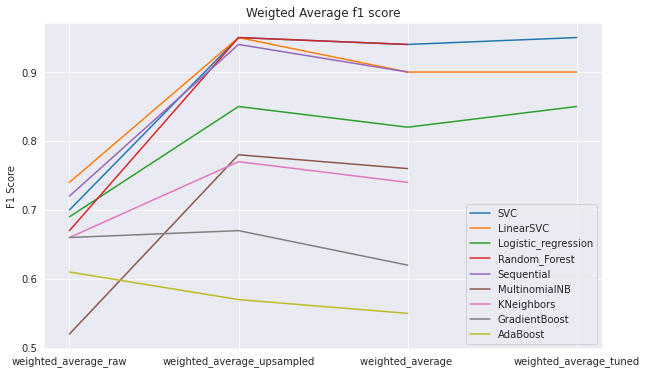

In [ ]:
# display the performance of the tunned models.
_ = all_models_performance(tunned_re_performance)

###### Conclusion
In the process of transforming and tunning the parameters, we have ended up with a decline in performance, for that reason, we are going to use the models post upsampling but before parameter tunning as by far they are the best performing models.

In the dataframe displayed below, we display the performance from the upsampling section. 

In [ ]:
sampled_performance

,weighted_average,accuracy_score
SVC,0.95,0.950200
LinearSVC,0.95,0.947300
Random_Forest,0.95,0.946100
Sequential,0.94,0.936135
Logistic_regression,0.85,0.855500
MultinomialNB,0.78,0.786500
KNeighbors,0.77,0.773500
GradientBoost,0.67,0.676600
AdaBoost,0.57,0.587600


# Summary and Conclusion
In this notebook we explored data which entailed tweets related to climate change and their belief on whether the user/tweet is pro, neutral or anti the belief. The data had a sentiment category of News as well, this were tweets that entailed relevant information regarding the topic at hand.

We started off by exploring the data, then trained base models, transformed them and lastly, we tried tuning hyperparameters to try and improve the performance of the models.

Our top five models in this notebook are the LinearSVC, SVC, Random forest, logidtic regression and a sequential neural network that we have trained. The performance metric that we were more interested in was the weighted average f1 score. This is mainly because the f1 score is a measure of accuracy which considers both the precision and recall scores.

We have thus built predictive models which businesses can use to better understand their customer's take on climate change. Such a model can prove important in guiding business in terms of the strategies to be adopted in production, marketing etc.

## Kaggle Submission

In [ ]:
# split into dependent and independent arrays
X = train_data['message'].values
y = train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=4)

train_models = {'SVC':svc_clf}

# train the model
sampled_performance, sampled_trained_models = models_to_train(X_train,X_test,
                                                  y_train,y_test,train_models)

# make predictions and return a dataframe.
y_pred = sampled_trained_models['SVC'].predict(test_data.message.values)
pd.DataFrame(data = y_pred,index = list(test_data.index),
             columns=['sentiment']).reset_index().rename({'index':'tweetid'},
                          axis=1).set_index('tweetid').to_csv('submit_me.csv')

# Dictionaries for data to log into Comet

In [ ]:
#batch_size = 50
#num_classes = 4
#epochs = 5
#num_nodes = 4
#optimizer = 'adam'
#activation = 'softmax'




#params={'batch_size':batch_size,
        # 'epochs':epochs,
        # 'layer1_type':'Dense',
        # 'layer1_num_nodes':num_nodes,
        # 'layer1_activation':activation,
        # 'optimizer':optimizer
        # }


#metrics = {'performance':performance}
#experiment.log_metrics(metrics)

#experiment.log_parameters(params)


In [ ]:
#experiment.end()

In [ ]:
#experiment.display()